deep convolutional generative adversarial networks for Simpsons faces (https://www.kaggle.com/datasets/kostastokis/simpsons-faces)

About Dataset

Dataset contains Simpsons faces, extracted from seasons 25-28. 

Cropped images are as extracted directly from the video files.

All images are 200x200 pixels, each centered on a single face. 

In [ ]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)
import random
from tensorflow.random import set_seed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/GIT_AI


In [ ]:
# from zipfile import ZipFile

# with ZipFile('DATA/cropped.zip', 'r') as zip_ref:
#     zip_ref.extractall('DATA/simpsons/')

In [ ]:
print(len(os.listdir('DATA/simpsons/cropped/')))

9861


In [ ]:
os.listdir('DATA/simpsons/cropped/')[5000:5005]

['5513.png', '5514.png', '5515.png', '5516.png', '5517.png']

In [ ]:
test = imread('DATA/simpsons/cropped/5513.png')

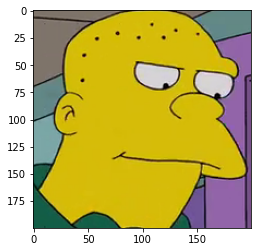

In [ ]:
plt.imshow(test)

## Reshape and Rescale Images for DCGAN

Generator is using `tanh` activation function for the last layer, so rescaling of `X_train` to be within -1 to 1 limits is needed. To faster calculation conversion to grayscale and image size = [104, 104] is applied. 

In [ ]:
image_gen = ImageDataGenerator(preprocessing_function=lambda x: x/255*2. - 1.) 

In [ ]:
X_train = image_gen.flow_from_directory('DATA/simpsons/', target_size=(96, 96), color_mode='grayscale', batch_size=64)

Found 9861 images belonging to 1 classes.


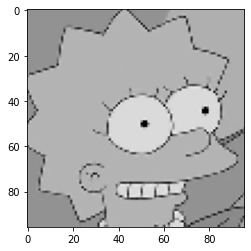

In [ ]:
batch=next(X_train)
plt.imshow(batch[0][0][:, :, 0], cmap='gray')

## Model training

In [ ]:
def reset_random_seeds(seeds):
   os.environ['PYTHONHASHSEED']=str(2)
   set_seed(seeds)
   np.random.seed(2022)
   random.seed(2022)

In [ ]:
reset_random_seeds(2022)

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3),
                        input_shape=[96, 96, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(32, kernel_size=5, strides=2, padding="same",
                        activation=LeakyReLU(0.3)))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [ ]:
discriminator.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 dropout_29 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 dropout_30 (Dropout)        (None, 24, 24, 128)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 12, 12, 64)        204864    
                                                                 
 dropout_31 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 6, 6, 32)        

In [ ]:
generator = Sequential()
generator.add(Dense(6*6*32, input_shape=[500]))
generator.add(Reshape([6, 6, 32]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",
                                 activation="relu"))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",
                                 activation="tanh"))

In [ ]:
generator.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1152)              577152    
                                                                 
 reshape_7 (Reshape)         (None, 6, 6, 32)          0         
                                                                 
 batch_normalization_23 (Bat  (None, 6, 6, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 12, 12, 64)       51264     
 Transpose)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 12, 12, 64)       256       
 chNormalization)                                                
                                                     

In [ ]:
# "weights-{epoch:03d}-{val_loss:.4f}.hdf5"
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_loss', 
#                                 verbose=0, save_best_only=True, mode='min' )
# checkpoint = tf.train.Checkpoint(model)
# checkpoint.restore(checkpoint_dir)


# loaded_model = keras.models.load_model('best_model')
# new_history = loaded_model.fit(train_dataset, epochs=20,
#                     validation_data=test_dataset,
#                     validation_steps=30,
#                     callbacks=[stop_early, checkpoint],
#                     )

In [ ]:
GAN = Sequential([generator, discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False 

In [ ]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

### Setting up Training Batches

In [ ]:
X_train[154][0].shape

(5, 96, 96, 1)

In [ ]:
epochs = 30
# Grab the seprate components
generator, discriminator = GAN.layers

for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for b in range(len(X_train)-1): #drop last batch
        X_batch = X_train[b][0]
        i=i+1
        if i%20 == 0:
            GAN.save(f'GAN_batch_{i}.h5')
            print(f"\tCurrently on batch number {i} of {len(X_train)}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[64, 500])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch[0], tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]]*64 + [[1.]]*64)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[64, 500])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]]*64)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/GIT_AI/
# from tensorflow.keras.models import load_model
# model.save('simpleRNN_unempl.h5')
# # model = load_model('....h5')
# hist_json_file = 'simpleRNN_unempl_history.json' 
# with open(hist_json_file, mode='w') as f:
#      pd.DataFrame(model.history.history).to_json(f)

# import joblib
# joblib.dump(full_scaler,'RNNscaler_unempl.pkl')

In [ ]:
noise = tf.random.normal(shape=[5, 500]) #generate 5 images

In [ ]:
noise.shape

TensorShape([10, 100])

In [ ]:
plt.imshow(noise)

In [ ]:
images = generator(noise)

In [ ]:
single_image = images[0]

In [ ]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()